In [1]:
using JuMP, Ipopt
using Plots

# Terrain function
basicTerrain(x, y) = exp(-1(x^2 + y^2)) + exp(-0.5((x-2)^2 + y^2)) 

# Discrete time
k = 4
instances = zeros(Int,4)  
wps = zeros(2,k)    

instances[1] = 1
instances[2] = 30
instances[3] = 70
instances[4] = 100

# Define waypoints
wps = [-2 -2;
        0  0;
        1  0;
       -2 -2]

function least_dangerous(λ, ξ, δ) 

    m = Model(Ipopt.Optimizer)
    register(m, :basicTerrain, 2, basicTerrain, autodiff=true)
    register(m, :sum, 1, sum; autodiff = true)
    set_optimizer_attributes(m, "print_level" => 0 )
    @variable(m, position[1:instances[k], 1:2]) # Position
    @variable(m, speed[1:instances[k], 1:2])    # Velocity
    @variable(m, thrust[1:instances[k], 1:2])   # Thrust
    @variable(m, height[1:instances[k], 1:1])   # Height

    # Initial speed
    @constraint(m, speed[1,:] .== [0 0])

    # Speed and thrust hard caps
    @constraint(m, [-0.5 -0.5] .<= speed .<= [0.5 0.5])
    @constraint(m, [-0.5 -0.5] .<= thrust .<= [0.5 0.5])

    for t in 1:instances[k]-1
        # Height update
        @NLconstraint(m, height[t,:1] == basicTerrain(position[t,:]...))

        # Height diference cap
        #@constraint(m, -0.05 <= height[t+1,:1] - height[t,:1] <= 0.05)
        
        # Dynamics
        @constraint(m, position[t+1,:] .== position[t,:] + speed[t,:])
        @NLconstraint(m, speed[t+1,:1] == speed[t,:1] + thrust[t,:1] + height[t+1,:1] - height[t,:1])
        @NLconstraint(m, speed[t+1,:2] == speed[t,:2] + thrust[t,:2] + height[t+1,:1] - height[t,:1])
    end

    # Reach all waypoints
    for i in [1 k]
        @constraint(m, position[instances[i],:] .== wps[i,:])
    end

    @objective(m, Min, δ * sum((position[instances[2:k],:] - wps[2:k,:]).^2) + ξ * sum((height[2:k,1] - height[1:k-1,1]).^2) + λ * sum(thrust.^2))
    optimize!(m)
    
    speed = value.(speed)
    thrust = value.(thrust)
    path = value.(position)
    height = value.(height)
    
    return (speed,thrust,path,height)
end

least_dangerous (generic function with 1 method)

In [2]:
λ = 1     # Reach waypoint
ξ = 10    # Reduce risk
δ = 5    # Reduce thrust
(speed, thrust, path, height) = least_dangerous(λ, ξ, δ)
println("Simulação concluída!")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulação concluída!


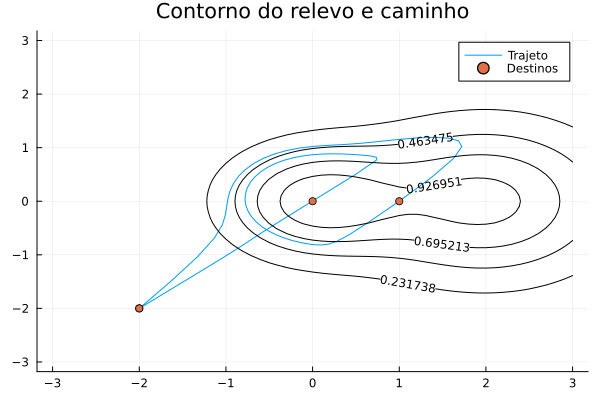

In [266]:
plot(path[:,1], path[:,2], label="Trajeto")
scatter!(wps[:,1], wps[:,2], label="Destinos")
contour!(-3:0.1:3, -3:0.1:3, basicTerrain, color=:black, clabels=true, levels=4, cbar=false, title="Contorno do relevo e caminho")

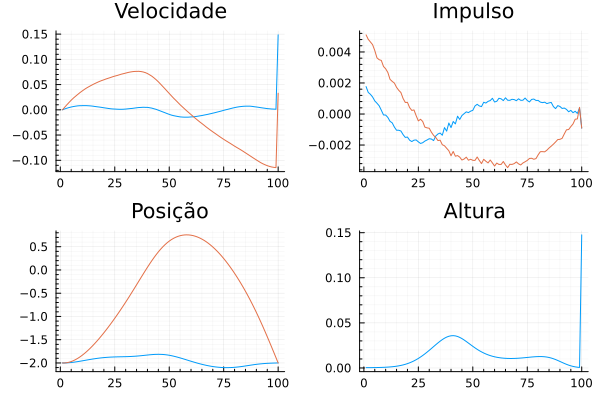

In [262]:
# Plot of the properties
p1 = plot(speed, title="Velocidade")
p2 = plot(thrust, title="Impulso")
p3 = plot(path, title="Posição")
p4 = plot(height, title="Altura")

plot!(p1, p2, p3, p4, layout=(2, 2), legend=false, minorgrid=true)

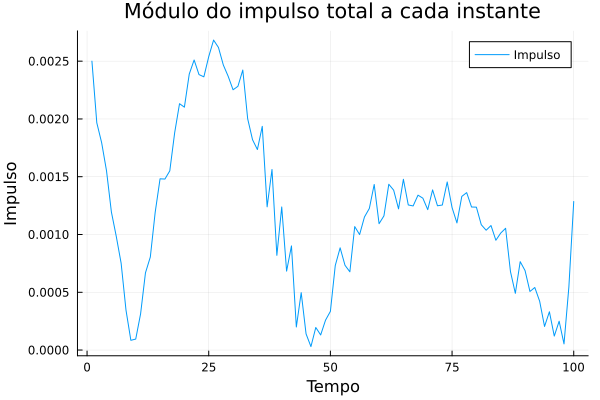

In [263]:
# Module of the total impulse at each instant
plot(sqrt.(thrust[:,1].^2  + thrust[:,1].^2), 
  label="Impulso", 
  title="Módulo do impulso total a cada instante", 
  xlabel="Tempo", 
  ylabel="Impulso")